# Hyperparameter Tuning with SageMaker Automatic Model Tuner

In [part3](../part3/twitter_volume_forecast.ipynb) we have trained a DeepAR model. Apart from prediction_length, time freqency and number of epochs we did not specify any hyperparameters. DeepAR has many hyperparameters and in this section we will use SageMaker automatic model tuner to find the right set for our model. Here is a short list of some hyperparameter and their default value:

| Hyperparameters          | Value                     |
|--------------------------|---------------------------|
| epochs                   | 100                       |
| context_length           | prediction_length         | 
| number training examples | 8606                      |
| batch size               | 32                        |
| learning rate            | $1e-3$                    |
| LSTM layers              | 2                         |
| LSTM nodes               | 40                        |
| likelihood               | StudentTOutput()                  |

Refer to the  [documentation](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) for a full description of the available parameters.

For example, you will elect the Gaussian likelihood model because you have real-valued data. Other likelihood models can also readily be used as long as samples from the distribution can cheaply be obtained and the log-likelihood and its gradients with respect to the parameters can be evaluated. For example:

- **Gaussian:** Use for real-valued data.
- **Beta:** Use for real-valued targets between 0 and 1 inclusive.
- **Negative-binomial:** Use for count data (non-negative integers).
- **Student-T:** An alternative for real-valued data that works well for bursty data.
- **Deterministic-L1:** A loss function that does not estimate uncertainty and only learns a point forecast.

First we have to upload our training dataset to Amazon S3. 

In [1]:
import pandas as pd
import gluonts
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import json
import boto3
import s3fs
import csv
import sagemaker

INFO:root:Using GPU
INFO:root:Using GPU


In [2]:
sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker_session.default_bucket()
s3_train_data_path = "s3://{}/gluonts/train".format(s3_bucket)
s3_test_data_path = "s3://{}/gluonts/test".format(s3_bucket)

Write train and test data to a csv file:

In [4]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(filepath_or_buffer=url, header=0, index_col=0)

train = df[: "2015-04-05 00:00:00"]
train.to_csv("train.csv")

test = df[: "2015-04-15 00:00:00"]
test.to_csv("test.csv")

The following function will upload the training dataset to the S3 bucket

In [5]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

Upload to S3

In [ ]:
%time
copy_to_s3("train.csv", s3_train_data_path + "/train.csv")
copy_to_s3("test.csv", s3_test_data_path + "/test.csv")

Let's have a look to what we just wrote to S3.

In [32]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_train_data_path + "/train.csv", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

timestamp,value
...


Next we define the MXNet esimtator. But first we get our SageMaker execution role.

In [33]:
import sagemaker
from sagemaker.mxnet import MXNet

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

MXNet estimator

In [47]:
mxnet_estimator = MXNet(entry_point='train.py',
                        source_dir='entry_point',
                        role=role,
                        train_instance_type='ml.m5.xlarge',
                        train_instance_count=1,
                        framework_version='1.4.0', py_version='py3',
                        hyperparameters={
                         'epochs': 1, 
                         'prediction_length':12,
                         'num_layers':2, 
                         'dropout_rate': 0.2,
                         })

Let's start the training job:

In [ ]:
mxnet_estimator.fit({"train": s3_train_data_path, "test": s3_test_data_path})

Let's deploy the model:

In [ ]:
endpoint = mxnet_estimator.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

Send some testdata to the endpoint:

In [ ]:
input_data = {'value': test.value.tolist(), 'timestamp': test.index.tolist() }
result = endpoint.predict(input_data)

The endpoint will return aggregated metrics:

In [46]:
result

{'MSE': 244.63037109375,
 'abs_error': 142.8305206298828,
 'abs_target_sum': 665.0,
 'abs_target_mean': 55.416666666666664,
 'seasonal_error': 12.780532802007231,
 'MASE': 0.9313025967081927,
 'sMAPE': 0.21119329684305851,
 'MSIS': 9.905241087165003,
 'QuantileLoss[0.1]': 60.613216400146484,
 'Coverage[0.1]': 0.16666666666666666,
 'QuantileLoss[0.2]': 86.71649475097658,
 'Coverage[0.2]': 0.4166666666666667,
 'QuantileLoss[0.3]': 115.22715072631836,
 'Coverage[0.3]': 0.4166666666666667,
 'QuantileLoss[0.4]': 134.08475952148436,
 'Coverage[0.4]': 0.5833333333333334,
 'QuantileLoss[0.5]': 142.8305206298828,
 'Coverage[0.5]': 0.5833333333333334,
 'QuantileLoss[0.6]': 146.86789093017578,
 'Coverage[0.6]': 0.75,
 'QuantileLoss[0.7]': 142.40164947509766,
 'Coverage[0.7]': 0.75,
 'QuantileLoss[0.8]': 115.67144622802732,
 'Coverage[0.8]': 0.75,
 'QuantileLoss[0.9]': 76.71700744628906,
 'Coverage[0.9]': 0.9166666666666666,
 'RMSE': 15.640664023427842,
 'NRMSE': 0.2822375462874197,
 'ND': 0.21478

Now that we are able to run our DeepAR model with SageMaker, we can start tuning its hyperparameter. In the following section we define the `HyperparameterTuner`, which takes the following hyperparameters:
- `epochs`: how many epochs shall the training be. If this value is too large we may overfit out training data, which means the model achieves good performance on the trasining dataset but bad performance on the validation dataset.
- `prediction_length`: how many time units shall the model predict
- `num_layers`: number of RNN layers
- `dropout_rate`: dropouts help to regularize the training because they randomly switch off neurons. 

You can find more information about DeepAR parameters [here](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) Next we have to indicate the metric we want to optimize on. We have to make sure that our training job prints those metrics. [train.py](entry_point/train.py) prints the MSE value of evluated test dataset. These printouts will appear in Cloudwatch and the automatic model tuner will then automatically retrieve those outputs by using the regular expression indicated in `Regex`. 
Next we indicate the `max_jobs` and `max_parallel_jobs`. Here we will run 10 jobs in total and in each step we will start 5 parallel jobs.

In [62]:
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter 

tuner = HyperparameterTuner(estimator=mxnet_estimator,  
                               objective_metric_name='loss',
                               hyperparameter_ranges={
                                    'epochs': IntegerParameter(5,20),
                                    'prediction_length':IntegerParameter(5,20),
                                    'num_layers': IntegerParameter(1, 5),
                                    'dropout_rate': ContinuousParameter(0, 0.5) },
                               metric_definitions=[{'Name': 'loss', 'Regex': "MSE: ([0-9\\.]+)"}],
                               max_jobs=10,
                               max_parallel_jobs=5,
                               objective_type='Minimize')

Start the model tuner:

In [63]:
tuner.fit({'train': s3_train_data_path, "test": s3_test_data_path})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-mxnet-191127-0345


Now you can go to the SageMaker console and you will see your hyperparameter tuning jobs. The automatic model tuner will automatically evaluate which hyperparameters to choose next and it uses per default Bayesian optimziation.

We can track the status of the hyperparameter tuning jobs by running the following code. Get the name of your job from the sagemaker console.

In [75]:
tuning_job_name = 'NAME OF YOUR HYPERPARAMETER TUNING JOB'

In [87]:
sage_client = boto3.Session().client('sagemaker')

# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

10 training jobs have completed


Convert results into Pandas frame

In [88]:
import pandas as pd

job_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = job_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 10
{'lowest': 117.87075805664062, 'highest': 306.5559997558594}


,dropout_rate,epochs,num_layers,prediction_length,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,0.482745,13.0,2.0,11.0,sagemaker-mxnet-191127-0345-005-6d77643d,Completed,117.870758,2019-11-27 03:47:35+00:00,2019-11-27 03:49:36+00:00,121.0
3,0.477103,16.0,1.0,7.0,sagemaker-mxnet-191127-0345-007-14adcf9b,Completed,123.828262,2019-11-27 03:51:23+00:00,2019-11-27 03:53:13+00:00,110.0
9,0.071561,18.0,2.0,7.0,sagemaker-mxnet-191127-0345-001-938b14a2,Completed,140.021072,2019-11-27 03:47:30+00:00,2019-11-27 03:49:53+00:00,143.0
0,0.474947,5.0,1.0,9.0,sagemaker-mxnet-191127-0345-010-e9e04cd1,Completed,146.069031,2019-11-27 03:52:39+00:00,2019-11-27 03:53:51+00:00,72.0
1,0.367037,6.0,2.0,5.0,sagemaker-mxnet-191127-0345-009-049adfb0,Completed,163.936172,2019-11-27 03:52:14+00:00,2019-11-27 03:53:29+00:00,75.0
2,0.450676,18.0,5.0,13.0,sagemaker-mxnet-191127-0345-008-47c9bc32,Completed,254.050674,2019-11-27 03:51:52+00:00,2019-11-27 03:55:15+00:00,203.0
6,0.191261,11.0,2.0,17.0,sagemaker-mxnet-191127-0345-004-57acaf07,Completed,273.904755,2019-11-27 03:47:35+00:00,2019-11-27 03:49:28+00:00,113.0
7,0.393358,17.0,3.0,16.0,sagemaker-mxnet-191127-0345-003-6131b763,Completed,302.508667,2019-11-27 03:47:26+00:00,2019-11-27 03:50:17+00:00,171.0
4,0.494499,15.0,3.0,15.0,sagemaker-mxnet-191127-0345-006-47297f38,Completed,304.692841,2019-11-27 03:51:24+00:00,2019-11-27 03:55:23+00:00,239.0
8,0.154696,16.0,5.0,10.0,sagemaker-mxnet-191127-0345-002-6e26a47f,Completed,306.556000,2019-11-27 03:47:36+00:00,2019-11-27 03:50:43+00:00,187.0


Let's plot the results of the hyperparameter tuning job

In [89]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

ranges = job_analytics.tuning_ranges
figures = []

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(job_analytics)

for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

Loading BokehJS ...

Running hyperparamter tuning jobs may take a while so in the meantime freel free to check out [this notebook](deepar_datails.ipynb) that gives more in depth details about DeepAR.

### Deployment

Now that we have found a model with good hyperparameters we can deploy it.

In [ ]:
tuned_endpoint = tuner.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

Let's compare how much better our predictions are:

In [ ]:
input_data = {'value': test.value.tolist(), 'timestamp': test.index.tolist() }
result = tuned_endpoint.predict(input_data)
result

In this notebook you have learnt how to build and train a DeepAR model with GluonTS, how to tune and deploy it with Amazon SageMaker.

# Challenge
Now it is your turn to find even better hyperparameters for the model. Go to  [documentation](https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html) and try out other hyperparameters.

# Additional: How to build a custom container 

# Additional: how to deal with sparse timeseries

We may sometimes have sparse timeseries, which can be a problem for forecasting models. In order to improve predictions accurcay, we can resample the timeseries to have less granularity. For instance instead of predicting 5 minutes we only predict on an hourly basis.

In [93]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
data_file = pd.read_csv(url, date_parser=dateparse, index_col='timestamp')

Let's resample the timeseries to an hourly series.

In [94]:
data_file = data_file.reset_index().groupby(pd.Grouper(freq='1H', key='timestamp')).sum()

We need to prepare a new training dataset:

In [95]:
dataset = ListDataset([{"start":data_file.index[0], 
                       "target": data_file.value[:"2015-04-05 00:00:00"]}], 
                      freq="1H")

Create the trainer and model:

In [96]:
trainer = Trainer(epochs=EPOCHS)
estimator = DeepAREstimator(freq="1H", prediction_length=6, trainer=trainer)

INFO:root:Using CPU


Train the model

In [ ]:
predictor = estimator.train(training_data=dataset)

Create the test dataset

In [98]:
test_data = ListDataset([{"start":data_file.index[0], 
                          "target":data_file.value[:"2015-04-15 10:00:00"]}], 
                           freq="1H")


Plot some forecasts

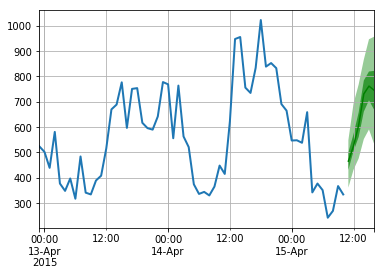

In [99]:
plot_forecast(predictor=predictor, test_data=test_data)